In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [8]:
path_home_team = "data/Train_Data/train_home_team_statistics_df.csv"
path_away_team = "data/Train_Data/train_away_team_statistics_df.csv"

path_test_home_team = "data/Test_Data/test_home_team_statistics_df.csv"
path_test_away_team = "data/Test_Data/test_away_team_statistics_df.csv"

path_home_team_ratings = "data/add/train/grouped_players_ratings/data_home_team_ratings.csv"
path_away_team_ratings = "data/add/train/grouped_players_ratings/data_away_team_ratings.csv"

path_test_home_team_ratings = "data/add/test/grouped_players_ratings/data_home_team_ratings.csv"
path_test_away_team_ratings = "data/add/test/grouped_players_ratings/data_away_team_ratings.csv"

path_target_wdl = "data/Y_train_1rknArQ.csv" 

In [9]:
data_home_team = pd.read_csv(path_home_team)
data_away_team = pd.read_csv(path_away_team)

data_test_home_team = pd.read_csv(path_test_home_team)
data_test_away_team = pd.read_csv(path_test_away_team)

data_home_team_ratings = pd.read_csv(path_home_team_ratings)
data_away_team_ratings = pd.read_csv(path_away_team_ratings)

data_test_home_team_ratings = pd.read_csv(path_test_home_team_ratings)
data_test_away_team_ratings = pd.read_csv(path_test_away_team_ratings)

target_wdl = pd.read_csv(path_target_wdl)

In [10]:
Y = target_wdl.HOME_WINS-target_wdl.AWAY_WINS

In [11]:
# utils function
def softmax(scores):
    exp_scores = np.exp(scores)
    if scores.shape[0]>1:
        probs = exp_scores / np.sum(exp_scores, axis=0)
    else:
        probs = exp_scores/(1+exp_scores)
    return probs

def predict_proba(model, X, mode = None):
    
    if mode is None:
        logits = model.coef_.dot(X.T) + model.intercept_.reshape((3, 1))
        Y_probs = softmax(logits).T
    
    elif mode == 'bin':
        logits = model.coef_.dot(X.T) + model.intercept_
        Y_probs = softmax(logits).T

    else:
        raise NotImplementedError        

    return Y_probs

# Trouver le nombre minimum de samples par classe
def split_balanced_data(X, Y=Y, test_size=0.66, random_state=10):

    X_train_unb, X_test_unb, Y_train_unb, Y_test_unb = train_test_split(X, Y, stratify=Y, test_size=test_size, random_state=random_state)
    min_samples_per_class = min(Y_train_unb.value_counts())

    X_train_list, X_test_list, Y_train_list, Y_test_list = [], [X_test_unb], [], [Y_test_unb]
    for class_label in Y.unique():
        
        X_train_c_balanced = X_train_unb[Y == class_label][:min_samples_per_class]
        X_rest_train_c = X_train_unb[Y == class_label][min_samples_per_class:]
        Y_train_c_balanced = Y_train_unb[Y == class_label][:min_samples_per_class]
        Y_rest_train_c = Y_train_unb[Y == class_label][min_samples_per_class:]

        # Sélectionner un sous-ensemble avec le nombre minimum de samples par classe
        X_train_list.append(X_train_c_balanced)
        Y_train_list.append(Y_train_c_balanced)
        
        X_test_list.append(X_rest_train_c)
        Y_test_list.append(Y_rest_train_c)
        
    # Concaténer les données des différentes classes pour former l'ensemble d'entraînement et l'ensemble de test
    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    Y_train = pd.concat(Y_train_list)
    Y_test = pd.concat(Y_test_list)

    return X_train, X_test, Y_train, Y_test

In [12]:
# fill teams raw counts data, don't need to fill ratings data
data_home_team = data_home_team.fillna(data_home_team.mean(numeric_only=True))
data_away_team = data_away_team.fillna(data_away_team.mean(numeric_only=True))

data_test_home_team = data_test_home_team.fillna(data_test_home_team.mean(numeric_only=True))
data_test_away_team = data_test_away_team.fillna(data_test_away_team.mean(numeric_only=True))

In [13]:
# WDL vars
base_columns_of_interest1 = ['TEAM_GAME_WON_season',
                       'TEAM_GAME_DRAW_season',
                       'TEAM_GAME_LOST_season',
                       'TEAM_GAME_WON_5_last_match',
                       'TEAM_GAME_DRAW_5_last_match',
                       'TEAM_GAME_LOST_5_last_match']

columns_of_interest_group1 = [col + '_sum' for col in base_columns_of_interest1]

# off vars and game
base_columns_of_interest2 = [
"TEAM_SHOTS_TOTAL",
"TEAM_SHOTS_INSIDEBOX",
"TEAM_SHOTS_ON_TARGET",
"TEAM_ATTACKS",
"TEAM_PENALTIES",
"TEAM_DANGEROUS_ATTACKS",
"TEAM_CORNERS",
"TEAM_GOALS",
#"TEAM_PASSES",
#"TEAM_SUCCESSFUL_PASSES",
#"TEAM_SUCCESSFUL_PASSES_PERCENTAGE",
#"TEAM_SUBSTITUTIONS",
#"TEAM_BALL_POSSESSION"
]

suffix = ['_season_average', '_season_std', '_5_last_match_average', '_5_last_match_std']
columns_of_interest_group2 = [base_column+suf for suf in suffix for base_column in base_columns_of_interest2]

# def vars and/or game vars
base_columns_of_interest3 = [
"TEAM_SAVES",
"TEAM_FOULS",
"TEAM_YELLOWCARDS",
"TEAM_REDCARDS",
"TEAM_OFFSIDES",
"TEAM_BALL_SAFE",
"TEAM_INJURIES",
"TEAM_PASSES",
"TEAM_SUCCESSFUL_PASSES",
"TEAM_SUCCESSFUL_PASSES_PERCENTAGE",
"TEAM_SUBSTITUTIONS",
"TEAM_BALL_POSSESSION"
]
columns_of_interest_group3 = [base_column+suf for suf in suffix for base_column in base_columns_of_interest3]

columns_of_interest_group4 = [
                    'PLAYER_RATING_season_average',
                    'PLAYER_RATING_season_std',
                    'PLAYER_RATING_5_last_match_average',
                    'PLAYER_RATING_5_last_match_std'
                    ]

print(len(columns_of_interest_group1))
print(len(columns_of_interest_group2))
print(len(columns_of_interest_group3))
print(len(columns_of_interest_group4))

6
32
48
4


### Expert 1, 2, 3

In [14]:
columns_of_interest = columns_of_interest_group2[:]
X = data_home_team[columns_of_interest]- data_away_team[columns_of_interest]

print(X.shape, Y.shape)

(12303, 32) (12303,)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    stratify=Y,
                                                    test_size=0.66,
                                                    random_state=10
                                                    )

In [16]:
model = LogisticRegression()
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.48983982787473107
0.48460591133004927


In [17]:
def expert(columns_of_interest, test_size=0.66, random_state=50, expert_idx=None):

    if expert_idx is None: 
        X = data_home_team[columns_of_interest]- data_away_team[columns_of_interest]
    else:
        X = data_home_team_ratings[columns_of_interest] - data_away_team_ratings[columns_of_interest]
        
    X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                        Y,
                                                        stratify=Y,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                        )
    model = LogisticRegression()
    model.fit(X_train, Y_train)        

    return X_test, Y_test, model, model.score(X_train, Y_train), model.score(X_test, Y_test)

In [18]:
scores_expert = np.zeros((4, 2))

In [19]:
X_test1, Y_test1, model1, scores_expert[0, 0], scores_expert[0, 1] = expert(columns_of_interest_group1)
X_test2, Y_test2, model2, scores_expert[1, 0], scores_expert[1, 1] = expert(columns_of_interest_group2)
X_test3, Y_test3, model3, scores_expert[2, 0], scores_expert[2, 1] = expert(columns_of_interest_group3)
X_test4, Y_test4, model4, scores_expert[3, 0], scores_expert[3, 1] = expert(columns_of_interest_group4, expert_idx=4)

In [20]:
scores_expert

array([[0.4726273 , 0.48115764],
       [0.4809945 , 0.48743842],
       [0.48147263, 0.46908867],
       [0.45661009, 0.46490148]])

In [21]:
Y_pred1 = model1.predict(X_test1)
Y_pred2 = model2.predict(X_test2)
Y_pred3 = model3.predict(X_test3)
Y_pred4 = model4.predict(X_test4)

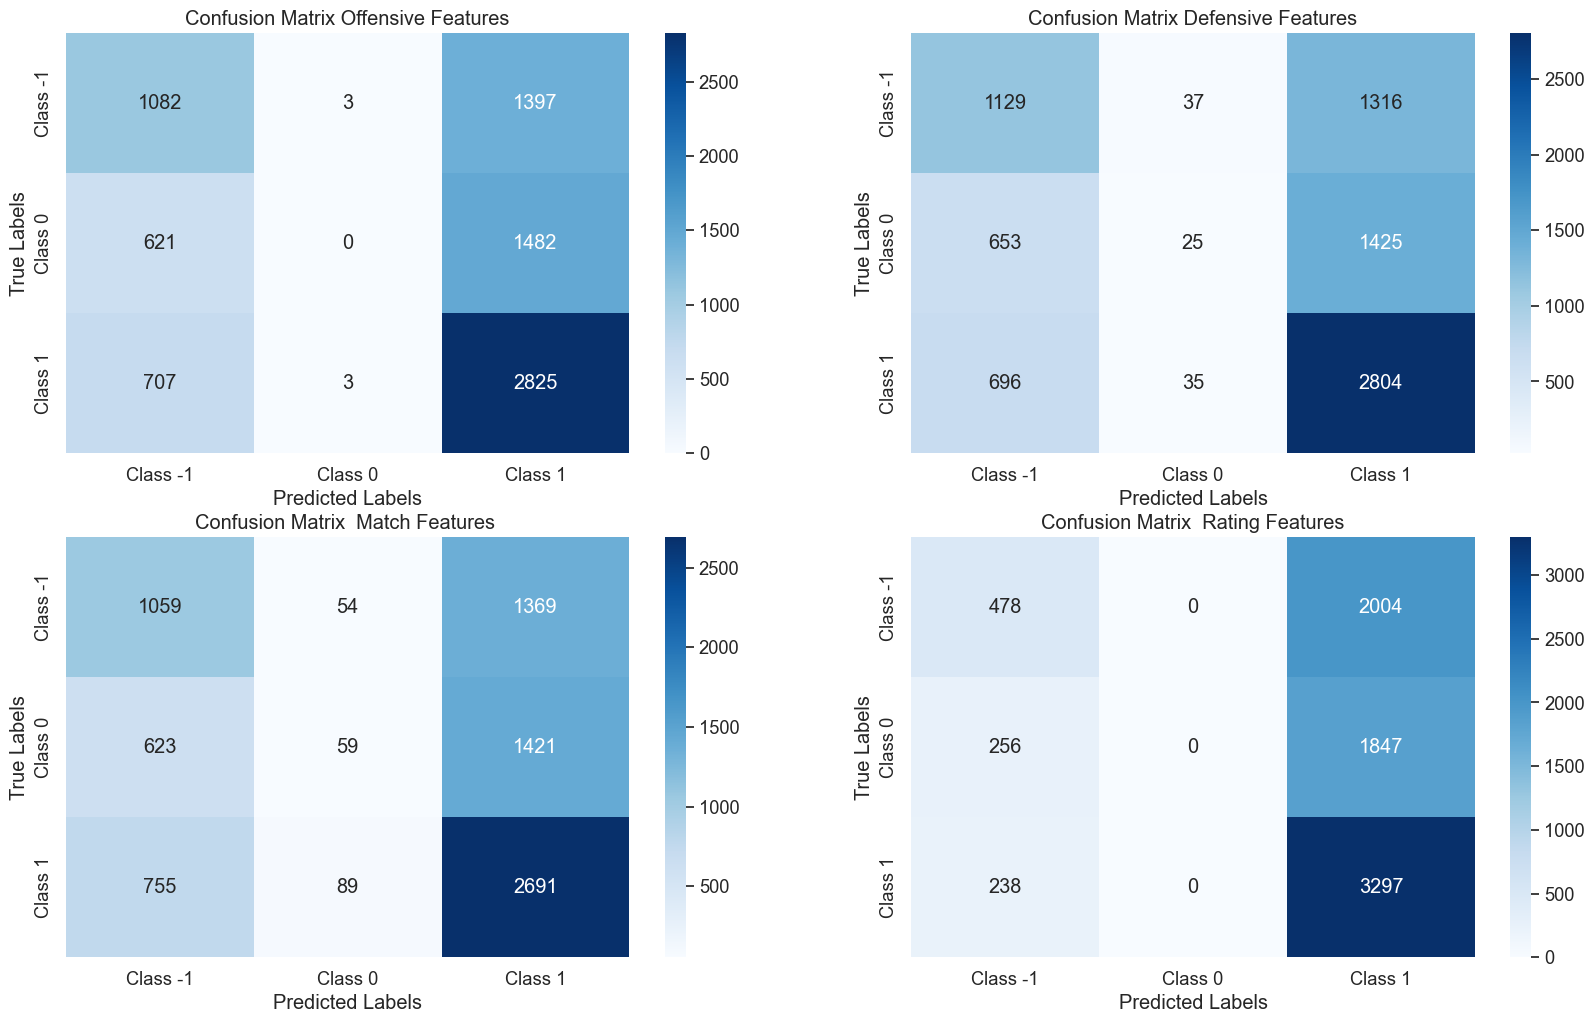

In [43]:
cms = [confusion_matrix(Y_test1, Y_pred1),
       confusion_matrix(Y_test2, Y_pred2),
       confusion_matrix(Y_test3, Y_pred3),
       confusion_matrix(Y_test4, Y_pred4)
       ]

cms_dict={0:"Offensive Features",1:"Defensive Features",2:" Match Features ",3:" Rating Features"}

# Labels des classes
classes = ['Class -1', 'Class 0', 'Class 1']

# Créer le graphique de la matrice de confusion
plt.figure(figsize=(20, 12))
for idx, cm in enumerate(cms):
    plt.subplot(2,2,idx+1)
    sns.set(font_scale=1.2)  # Réglage de la taille de police
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    # Ajouter des labels et un titre
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {cms_dict[idx]}')

plt.show()

In [23]:
def experts_agregator_n4(alls, experts_acc):
    """
    same function with four experts
    """

    agreement_distrib = np.zeros((alls.shape[1]))
    for sample in range(alls.shape[1]):
        unique = np.unique(alls[:, sample], return_counts=True)[1].max()
        agreement_distrib[sample] = unique

    prediction = np.zeros((alls.shape[1],))
    for idx, unique in enumerate(agreement_distrib):
        if unique == 4:
            prediction[idx] = alls[0, idx]
        else:
            unique_preds = np.unique(alls[:, idx], return_counts=True)
            if unique == 1:
                prediction[idx] = alls[0, idx]
            elif unique == 3:
                majority_class = unique_preds[0][unique_preds[1].argmax()]
                prediction[idx] = majority_class
            else:
                if len(unique_preds[0]) == 2: # vote [2,2]
                    acc_group0 = sum([experts_acc[i] for i in range(4) if alls[i, idx] == unique_preds[0][0]])/2
                    acc_group1 = sum([experts_acc[i] for i in range(4) if alls[i, idx] == unique_preds[0][1]])/2
                    if acc_group0 > acc_group1:
                        prediction[idx] = unique_preds[0][0]
                    else:
                        prediction[idx] = unique_preds[0][1]
                else: #vote [2,1, 1]
                    majority_class = unique_preds[0][unique_preds[1].argmax()]
                    prediction[idx] = majority_class

    return agreement_distrib, prediction

def experts_agregator_n3(alls):
    """
    same function with four experts
    """

    agreement_distrib = np.zeros((alls.shape[1]))
    for sample in range(alls.shape[1]):
        unique = np.unique(alls[:, sample], return_counts=True)[1].max()
        agreement_distrib[sample] = unique

    prediction = np.zeros((alls.shape[1],))
    for idx, unique in enumerate(agreement_distrib):
        if unique == 3 or unique==1: # les 3 experts sont d'accord/ont des avis différents
            prediction[idx] = alls[0, idx] # vote maj/priorité au 1er
        else: # 2 contre 1
            unique_preds = np.unique(alls[:, idx], return_counts=True)
            majority_class = unique_preds[0][unique_preds[1].argmax()]
            prediction[idx] = majority_class # vote majoritaire

    return agreement_distrib, prediction

In [24]:
(-scores_expert[:, 1]).argsort()

array([1, 0, 2, 3])

In [25]:
alls = np.vstack((Y_pred2, Y_pred1, Y_pred3, Y_pred4))
experts_acc = -np.sort(-scores_expert[:, 1])

In [26]:
experts_acc

array([0.48743842, 0.48115764, 0.46908867, 0.46490148])

In [27]:
_, Y_pred_Mo4E = experts_agregator_n4(alls, experts_acc)
_, Y_pred_Mo3E = experts_agregator_n3(alls[:3])

In [28]:
print((Y_pred_Mo4E == Y_test1).sum()/len(Y_test1))
print((Y_pred_Mo3E == Y_test1).sum()/len(Y_test1))

0.492487684729064
0.49088669950738917


#### prediction on real data

In [29]:
def expert_real_data(columns_of_interest, expert_idx=None):

    if expert_idx is None: 
        X = data_home_team[columns_of_interest]- data_away_team[columns_of_interest]
        X_test = data_test_home_team[columns_of_interest] - data_test_away_team[columns_of_interest]
    else:
        X = data_home_team_ratings[columns_of_interest] - data_away_team_ratings[columns_of_interest]
        X_test = data_test_home_team_ratings[columns_of_interest] - data_test_away_team_ratings[columns_of_interest]

    if expert_idx is None:        
        model = LogisticRegression()
        model.fit(X, Y)    

        Y_pred_real = model.predict(X_test)    
        Y_pred_train = model.predict(X)    
    else:
        model = SVC()
        model.fit(X, Y)    

        Y_pred_real = model.predict(X_test)    
        Y_pred_train = model.predict(X)
        
    return Y_pred_real, Y_pred_train, model.score(X, Y)

In [30]:
scores_all_data = np.zeros((4,))

In [31]:
Y_pred_real1, Y_pred_train1, scores_all_data[0]  = expert_real_data(columns_of_interest_group1)
Y_pred_real2, Y_pred_train2, scores_all_data[1]  = expert_real_data(columns_of_interest_group2)
Y_pred_real3, Y_pred_train3, scores_all_data[2]  = expert_real_data(columns_of_interest_group3)
Y_pred_real4, Y_pred_train4, scores_all_data[3]  = expert_real_data(columns_of_interest_group4, expert_idx=4)

In [32]:
scores_all_data

array([0.48045192, 0.48882386, 0.48215882, 0.47598147])

In [33]:
alls = np.vstack((Y_pred_train2, Y_pred_train3, Y_pred_train1, Y_pred_train4))
experts_acc = -np.sort(-scores_all_data)

In [34]:
_, Y_pred_train_Mo4E = experts_agregator_n4(alls, experts_acc)
print((Y_pred_train_Mo4E == Y).sum()/len(Y))

0.49321303747053563


Final test set pred

In [35]:
alls_real = np.vstack((Y_pred_real2, Y_pred_real3, Y_pred_real1, Y_pred_real4))
experts_acc = -np.sort(-scores_all_data)

_, Y_pred_real_Mo4E = experts_agregator_n4(alls_real, experts_acc)

In [36]:
Y_pred_real_Mo4E.shape

(25368,)

In [37]:
np.unique(Y_pred_real_Mo4E, return_counts=True)

(array([-1.,  0.,  1.]), array([ 6923,     2, 18443]))

In [38]:
np.save('submit4.npy', Y_pred_real_Mo4E)

In [39]:
Y_submit = pd.DataFrame([], columns = ['ID','HOME_WINS','DRAW','AWAY_WINS'])
Y_submit['ID'] = data_test_home_team.ID 

home_wins = np.zeros(Y_pred_real_Mo4E.shape, dtype=int)
draws = np.zeros(Y_pred_real_Mo4E.shape, dtype=int)
away_wins = np.zeros(Y_pred_real_Mo4E.shape, dtype=int)

for count, i in enumerate(Y_pred_real_Mo4E):
    if i==1:
        home_wins[count]=1
    elif i==-1:
        away_wins[count]=1
    else:
        draws[count]=1

Y_submit['HOME_WINS'] = home_wins
Y_submit['DRAW'] = draws
Y_submit['AWAY_WINS'] = away_wins

Y_submit

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,1,0,0
1,12304,0,0,1
2,12305,1,0,0
3,12306,0,0,1
4,12307,1,0,0
...,...,...,...,...
25363,37666,0,0,1
25364,37667,1,0,0
25365,37668,1,0,0
25366,37669,1,0,0


In [41]:
Y_submit.to_csv("data/submissions/s4_MoE_balanced_svc_exp4.csv", index = False)